In [38]:
import pandas as pd
import numpy as np
from ipywidgets import interact
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from tqdm.auto import tqdm

In [4]:
transactions = pd.read_csv("../data/dunnhumby_The-Complete-Journey/dunnhumby - The Complete Journey CSV/transaction_data.csv")

# Spending trends over time

We analyze how much people spend on shopping and how that value changes over time.

In [5]:
def plot_trend(x, y, xlabel, ylabel, title, std=None):
    plt.figure(figsize=(10,8))
    
    plt.plot(x, y, label="Actual values")
    
    reg = LinearRegression()
    x_reg = x.to_numpy().reshape(-1, 1)
    reg.fit(x_reg, y)
    plt.plot(x, reg.predict(x_reg), label="Linear trend")
    if std is not None:
        plt.fill_between(monthly.index, monthly - std, monthly + std, alpha=0.2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

First we compute the mean household spending each week and see how it looks over time. It seems there is an overall rising trend.

In [6]:
# we compute mean 
weekly = transactions.groupby(["household_key", "WEEK_NO"])["SALES_VALUE"].sum().groupby("WEEK_NO").mean().sort_index()

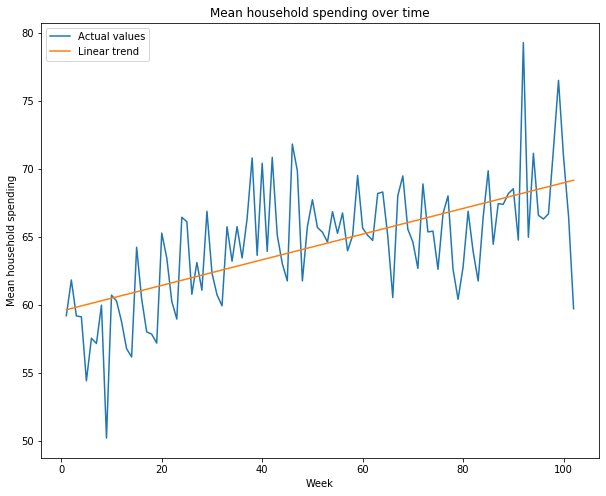

In [7]:
plot_trend(weekly.index, weekly, "Week", "Mean household spending", "Mean household spending over time")

<font color = "green">
               
* There is a high deviation between subsequent weeks but we can see that the sales are overall increasing over time. The linear regression shows a rising tendency.

* The big drop in the last week is most likely caused by the fact that this week is underrepresented (it doesn't contain the last day).

In [9]:
# compute an approximation of which month we are in (assuming all months are 30 days)
transactions["MONTH"] = (np.floor(transactions["DAY"] / 30) + 1).apply(int)

In [17]:
# Now we compute mean household spending in each month
monthly = transactions.groupby(["household_key", "MONTH"])["SALES_VALUE"].sum().reset_index().groupby("MONTH")["SALES_VALUE"].mean()

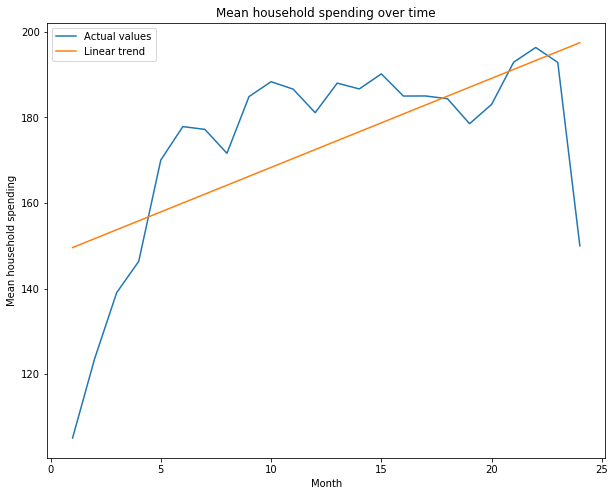

In [18]:
plot_trend(monthly.index, monthly, "Month", "Mean household spending", "Mean household spending over time")

As week by week data has very high variance (which is likely caused by for example some people doing big shopping only every two weeks etc.), we look at the monthly spending.

The plot is much smoother and we can indeed see an increasing trend, especially at the very beginning (in the first half a year). After half a year the trend seems to still be rising, however it slows down a lot in comparison to the first months.

It is important to note how we should understand the data we have: we have sales data for a specific set of stores. The fact that we see an increase in spending over time what we really see is increase in store's sales. It is possible that it is due to the people startin o spend more money, but it is equally possible that they are spending the same amount, but choosing the stores we have access to more frequently instead of other stores that are not in this database. In fact the big rise in the first half a year could be explained by the store starting a marketing campaign - the small sales in the beginning could mean new customers starting to sometimes go to this stores and the rapid increase could be the result of them starting to choose it more and more often over other stores due to marketing. The slowdown afterwards may be due to saturation - most interested customers already have started to frequent these stores often and they don't change their habits that much anymore.

In [12]:
monthly_sales = transactions.groupby(["MONTH"])["SALES_VALUE"].sum()

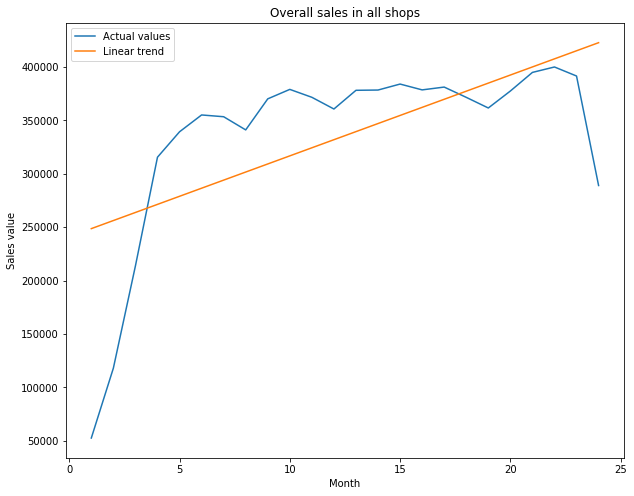

In [14]:
plot_trend(monthly_sales.index, monthly_sales, "Month", "Sales value", "Overall sales in all shops")

Looking at overall sales in all the shops makes the hypothesis from above even more likely - as we can see both plots are very similar. It seems that the shop chain was indeed gaining popularity very rapidly in the first 5-6 months, likely due to effective marketing.

## Individual trends

However people are not a namelss mass but a group of individuals. The mean household spending seems to be rising, but does that mean that all the people are spending more and more? Let's find out.

In [48]:
def find_absolute_coef(data):
    data = data.rename("count").sort_index().reset_index()
    model = LinearRegression()
    X = data["WEEK_NO"].to_numpy() / 102
    y = data["count"].to_numpy()
    # we fit a Linear Regression to find a line best fitting the change in spending over time
    model.fit(X.reshape(-1,1),y.reshape(-1,1))
    return model.coef_[0][0]

In [82]:
def find_percentage_change(data):
    data = data.rename("count").sort_index().reset_index()
    model = LinearRegression()
    X = data["WEEK_NO"].to_numpy() / 102
    y = data["count"].to_numpy()
    # we fit a Linear Regression to find a line best fitting the change in spending over time
    model.fit(X.reshape(-1,1),y.reshape(-1,1))
    
    # we now compute the percentage change    
    return (100 * (model.coef_[0][0]) / model.intercept_[0])

In [30]:
weekly = transactions.groupby(["household_key", "WEEK_NO"])["SALES_VALUE"].sum()

In [39]:
tqdm.pandas()

/home/radeusgd/Anaconda3/envs/ada/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


We now try to fit a Linear Regression model to the weekly spending of each household. The fitted line represents a 'trend' in the spending of the household - if the line is going upwards it means the household is spending more and if it is downwars the household is likely to started saving. A horizontal line means the spending stays more or less the same.

We will compute a percentage spending change - we fit the line to weekly spending (to avoid the high variance, the line is an approximation of a long term tendency) and assume the line's height in the first week is the starting value and its height in the last week is the final value and compute the percentage difference between the two.

In [50]:
absolute_trends = weekly.groupby("household_key").progress_apply(find_absolute_coef)

In [83]:
percentage_trends = weekly.groupby("household_key").progress_apply(find_percentage_change)

We drop some extreme outliers to see the data in more detail. We have checked a random sample of the outliers and it seems it's mostly just caused by households that did very few transactions which makes the trend approximation very imprecise.

In [59]:
absolute_trends = absolute_trends[absolute_trends.abs() < 500]

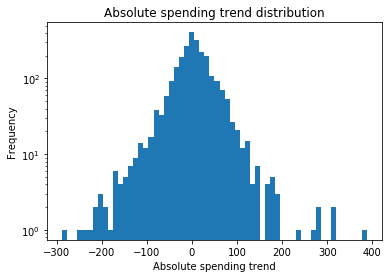

In [63]:
absolute_trends.plot.hist(bins=60, log=True)
plt.title("Absolute spending trend distribution")
plt.xlabel("Absolute spending trend")
plt.show()

The absolute spending trend is just the coefficient of the linear trend - it is very dependent on the initial value. If someone was spending 200k in the beginning and in the end they are spending 210k, the coefficient would be the same as in the case someone was spending 10k and started spending 20k, but in fact these changes are drastically different (5% vs 100% increase).

That is why we will now analyse the percentage change described earlier - it is a better metric in terms of habits. Because a 2x is different from a 5% change.

In [84]:
100 * (percentage_trends.abs() > 1000).sum() / len(percentage_trends)

3.0

Only 3% of samples are extreme outliers, so we just drop them to make the histograms more readable. They are likely caused by households doing very few transactions and the trend approximation being imprecise with a small number of samples.

In [85]:
percentage_trends = percentage_trends[percentage_trends.abs() < 1000]

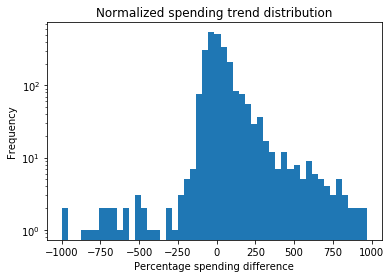

In [87]:
percentage_trends.plot.hist(bins=50,log=True)
plt.title("Normalized spending trend distribution")
plt.xlabel("Percentage spending difference")
plt.show()

In [128]:
np.mean(percentage_trends)

32.453319262364886

A positive value means the spending has been increased - for example 100% means the spending is now twice as at the beginning, 0% means no change and -50% means the spending has decreased by 50% since the beginning.

Values smaller then -100% may look suspicious - what they represent is samples where there wasn't too much data so the approximated spending trend is indicating that at the end of the period they would be spending negative amounts which is of course illogical.
We can however treat these values just as big negative values, because these customers were spending much less over time.

What can be read from this histogram is that there more people who have an increase in spending than those who have a decrease. So our initial intuition was right - most people do spend more money in these stores. The average spending increase is 32%.

There are however lots of people that are spending less as well.

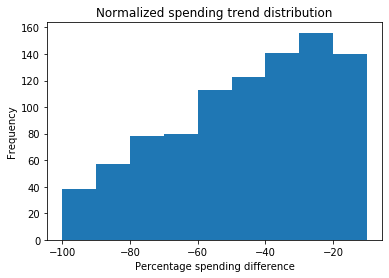

In [135]:
percentage_trends.plot.hist(bins=range(-100,0,10))
plt.title("Normalized spending trend distribution")
plt.xlabel("Percentage spending difference")
plt.show()

In [139]:
neg = percentage_trends[percentage_trends < 0]

In [142]:
100.0 * (neg > -50).sum() / len(neg)

61.53846153846154

The majority of people (who are saving) have decreased their spending by less than 50%

In [143]:
(percentage_trends > 0).sum(), (percentage_trends < 0).sum()

(1252, 1170)

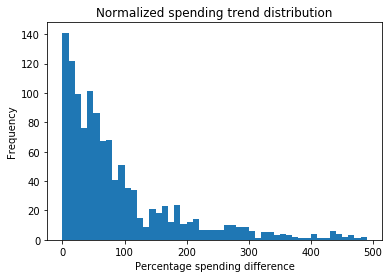

In [134]:
percentage_trends.plot.hist(bins=range(0,500,10))
plt.title("Normalized spending trend distribution")
plt.xlabel("Percentage spending difference")
plt.show()

In [145]:
((percentage_trends > 0) & (percentage_trends < 50 )).sum()

536

Among people who are spending more (the overall majority), most of them are spending only slightly more, but there are minorities that are spending even 4x as much as before.

## Spending on days of week

In [148]:
transactions["DAY_OF_WEEK"] = (transactions["DAY"] - 6) % 7 + 1

In [149]:
dow = transactions.groupby(["household_key", "DAY_OF_WEEK"])["SALES_VALUE"].sum().groupby("DAY_OF_WEEK").mean()

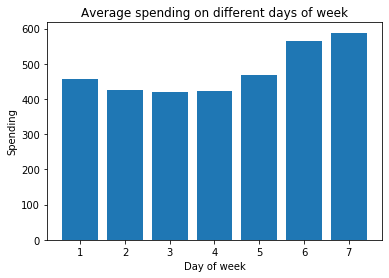

In [150]:
plt.bar(dow.index, dow)
plt.title("Average spending on different days of week")
plt.xlabel("Day of week")
plt.ylabel("Spending")
plt.show()

<font color = "green">

* It is only a hypothesis, but it seems that 1 = Monday indeed, as the last two days get higher spendings and people tend to go shopping on the weekends (at least in countries when most shops are open on Sundays, but if this shop was closed altogether it would have 0 sales or small sales in only specific shopping points, which would be clear from the plot).

* So we can conjecture that 1 = Monday, 7 = Sunday and people do most sales on the weekend (which seems reasonable as they have more time) and also a bit more than usual on Friday (after work, maybe in preparation for the weekend) and Mondays (maybe to refill after a weekend).



# Recurring trends in specific categories

In [158]:
def compare_specific_categories(data, category_column, labels, statistic_computation, sort=True, title=None):
    data = data[data[category_column].isin(labels)]
    
    values = data[category_column].unique()
    if sort:
        values = sorted(values)
    
    def summarize_category(category_name):
        filtered = data[data[category_column] == category_name]
        stat = statistic_computation(filtered)
        return stat
    
    stats = list(map(summarize_category, values))

    plt.figure(figsize=(10,8))
    for cat, stat in zip(values, stats):

        plt.plot(stat.index, stat, label=cat)
        #print(stat)
    plt.xlabel("Month")
    plt.ylabel("Relative sales in given month")
    if title is None:
        title = "Comparison over " + category_column
    plt.title(title)
    plt.legend()
    plt.show()

def stat_relative_overall_monthly_quantity(data):
    overall = data["QUANTITY"].sum()
    return (data.groupby("MONTH")["QUANTITY"].sum() / overall)

def stat_relative_minmax_overall_monthly_quantity(data):
    monthly = data.groupby("MONTH")["QUANTITY"].sum()
    mini = monthly.min()
    maxi = monthly.max()
    return (monthly - mini) / (maxi - mini)

In [153]:
products = pd.read_csv("../data/dunnhumby_The-Complete-Journey/dunnhumby - The Complete Journey CSV/product.csv")

In [154]:
merged = transactions.merge(products)

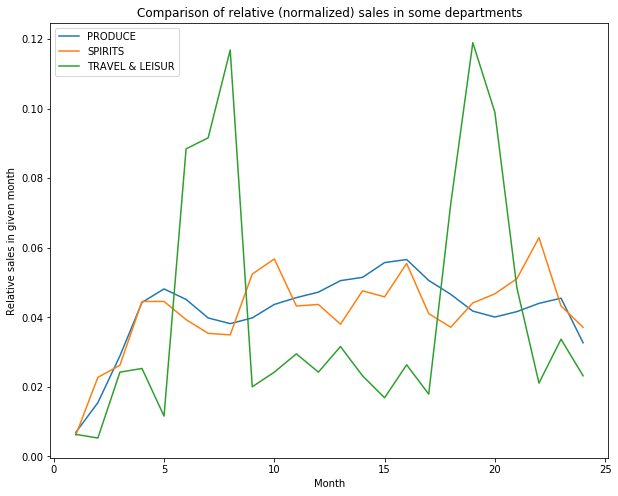

In [159]:
compare_specific_categories(merged, "DEPARTMENT", ["TRAVEL & LEISUR", "SPIRITS", "PRODUCE"], stat_relative_overall_monthly_quantity, title="Comparison of relative (normalized) sales in some departments")

<font color = "green">

* One can observe that TRAVEL has cyclical spikes in months 6-8 (which coincides with summer) likely due to people going on vacation.

* At the same time there is a light drop in SPIRITS and PRODUCE sales which is likely explained by people going on vacation don't do their regular shopping or do it elsewhere (possibly abroad).

# Sales at different times of day

In [160]:
transactions["HOUR"] = np.floor(transactions.TRANS_TIME / 100).apply(int)

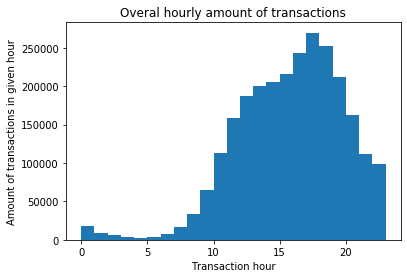

In [161]:
transactions.HOUR.plot.hist(bins=range(0,24))
plt.title("Overal hourly amount of transactions")
plt.xlabel("Transaction hour")
plt.ylabel("Amount of transactions in given hour")
plt.show()

In [170]:
demographic = pd.read_csv("../data/dunnhumby_The-Complete-Journey/dunnhumby - The Complete Journey CSV/hh_demographic.csv")

In [171]:
transactions_demographic = merged.merge(demographic)

In [174]:
transactions_demographic["HOUR"] = np.floor(transactions_demographic.TRANS_TIME / 100).apply(int)

In [172]:
def times_over_category(data, category_column, show_separate=True, sort=True, minimal_threshold=None):
    
    sums = data.groupby([category_column, "HOUR"])["QUANTITY"].sum()
    overall = data.groupby(category_column)["QUANTITY"].sum()
    if minimal_threshold is not None:
        sums = sums[sums.index.isin(overall[overall > minimal_threshold].index, level=0)]

    values = sums.index.unique(level=0)
    if sort:
        values = sorted(values)
        
    if show_separate:
        for cat in values:
            stat = sums[cat]
            plt.title("Shopping times for category " + cat)
            plt.xlabel("Hour")
            plt.ylabel("Amount of items bought")
            plt.bar(stat.index, stat)
            plt.show()
    
    # for the second step we normalize the sums
    
    sums = sums / overall

    
    plt.figure(figsize=(10,8))
    for cat in values:
        stat = sums[cat]
        plt.plot(stat.index, stat, label=cat)
    plt.xlabel("Hour")
    plt.ylabel("Relative sales amount")
    plt.title("Relativized comparison over " + category_column)
    plt.legend()
    plt.show()

<span style="color: red">In final version add interactive charts where one can look at times of individual groups</span>

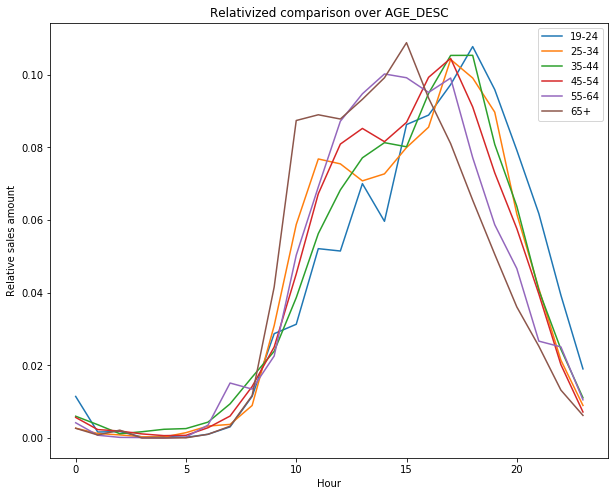

In [175]:
# TODO maybe normalize the gasoline
times_over_category(transactions_demographic[(transactions_demographic.SUB_COMMODITY_DESC != "GASOLINE-REG UNLEADED")], "AGE_DESC", show_separate=False)

<font color = "green">

* Here we can see that older people tend to do the shopping in the late morning and early afternoon - starting at 9, and with a peak activity at 15.

* Adults tend to do most of their shopping later - with most of them shopping around 17-18.

* The youngest age group (19-24) tend to do the shopping in the evening - peaking around 18 and being relatively more active in the night.


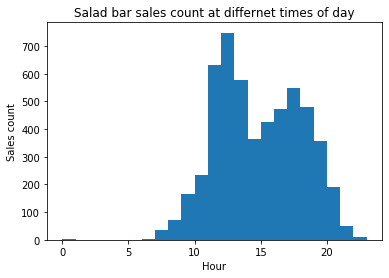

In [183]:
transactions_demographic[transactions_demographic.DEPARTMENT == "SALAD BAR"]["HOUR"].plot.hist(bins=range(24))
plt.title("Salad bar sales count at differnet times of day")
plt.ylabel("Sales count")
plt.xlabel("Hour")
plt.show()

As we can see the salad bar has a big spike at around 1pm which suggests lots of clients buy salads for lunch, the later increase around 5pm is likely caused by clients buying salads after work or during their normal shopping (overall sales also peak at ~5pm) for example for the next day.